In [9]:
import sys
sys.path.append("..")

import importlib
import numpy as np

import data_frame
import models

In [10]:
importlib.reload(data_frame)
importlib.reload(models)

filePath = "../../KiDS-DR5-WCScut_x_DESI-DR1-small.fits"
model_path = f"../../models/experiment2/BNN_last_3_layers_2/variables/variables"
df = data_frame.DataFrame(filePath, "QSO",)

config = {"num_components":3}
bnn = models.MLModelContext(strategy=models.BayesianNN(df, config))
bnn.load_weights(model_path)

filePath = "../KiDS-DR5-WCScut_x_DESI-DR1-small.fits"
model_path = f"../../models/experiment2/MG_3_components_3/variables/variables"

gmm = models.MLModelContext(strategy=models.MixtureGaussian(df, config))
gmm.load_weights(model_path)

/home/kdrabicki/anaconda3/envs/cpu_env/lib/python3.12/site-packages/tensorflow_probability/python/layers/util.py:99: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
/home/kdrabicki/anaconda3/envs/cpu_env/lib/python3.12/site-packages/tf_keras/src/initializers/initializers.py:121: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
/home/kdrabicki/anaconda3/envs/cpu_env/lib/python3.12/site-packages/tensorflow_probability/python/layers/util.py:109: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_vari

In [11]:
objects = np.linspace(500, 19500, 20, dtype=int)

scaler = bnn.strategy.scaler
X_test, y_test = bnn.strategy.X_test, bnn.strategy.y_test
X_test.dropna(inplace=True)
X_test.sort_values(by=["MAG_GAAP_r"], inplace=True)

points = np.arange(0,4,0.01)

bnn_net = bnn.strategy.network
gmm_net = gmm.strategy.network

bnn_points = []
gmm_points = []
for n in objects:
    y_pred = y_test[n:n+1]
    r_mag = X_test.iloc[n:n+1, 2].item()

    feat = scaler.transform(X_test[n:n+1])
    # BNN
    all_means = []
    all_probs = []
    
    for _ in range(100):
        dist = bnn_net(feat)
        all_means.append(dist.mean())
        all_probs.append([np.exp(dist.log_prob(point)) for point in points])
    
    bnn_points.append((np.mean(all_probs, axis=0), np.mean(all_means), y_pred, r_mag))
    
    # GMM
    dist = gmm_net(feat)
    gmm_points.append(([np.exp(dist.log_prob(point)) for point in points], dist.mean(), y_pred, r_mag))

2025-09-30 16:08:04.057195: E tensorflow/core/util/util.cc:131] oneDNN supports DT_INT32 only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


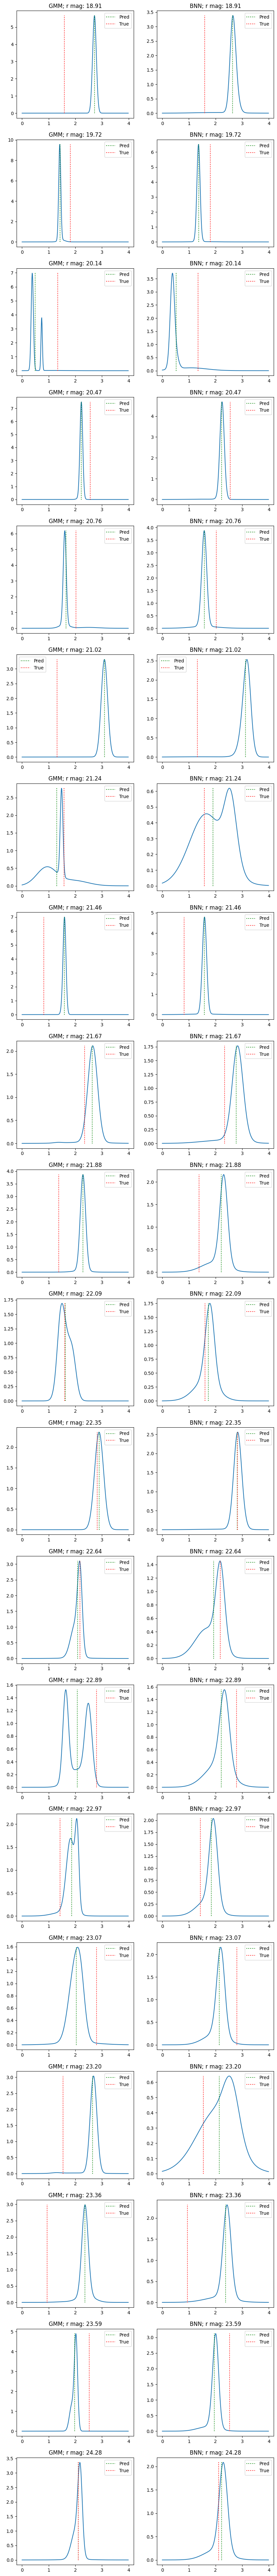

In [25]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(20,2, figsize=(10,100))

for i in range(20):
    axes[i][0].plot(points, gmm_points[i][0])
    axes[i][0].vlines(x = gmm_points[i][1], ymin=0, ymax=np.max(gmm_points[i][0]), colors="green", linestyles="dotted", label="Pred")
    axes[i][0].vlines(x = gmm_points[i][2], ymin=0, ymax=np.max(gmm_points[i][0]), colors="red", linestyles="dotted", label="True")
    axes[i][0].legend()
    axes[i][0].set_title(f"GMM; r mag: {gmm_points[i][3]:.2f}")
    
    axes[i][1].plot(points, bnn_points[i][0])
    axes[i][1].vlines(x = bnn_points[i][1], ymin=0, ymax=np.max(bnn_points[i][0]), colors="green", linestyles="dotted", label="Pred")
    axes[i][1].vlines(x = bnn_points[i][2], ymin=0, ymax=np.max(bnn_points[i][0]), colors="red", linestyles="dotted", label="True")
    axes[i][1].legend()
    axes[i][1].set_title(f"BNN; r mag: {bnn_points[i][3]:.2f}")

plt.subplots_adjust(hspace=0.2)
plt.show()

In [145]:
features = scaler.transform(X_test[500:501])
dist = gmm_net(features)

In [146]:
dist.log_cdf(4)

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([-8.92838e-05], dtype=float32)>

In [147]:
import tensorflow as tf

def percentile(dist, p, low=0.0, high=10.0, tol=1e-6, max_iter=100):
    
    low = tf.constant(low, dtype=tf.float32)
    high = tf.constant(high, dtype=tf.float32)
    p = tf.constant(p, dtype=tf.float32)

    for _ in range(max_iter):
        mid = (low + high) / 2
        cdf_mid = tf.exp(dist.log_cdf(mid))
        high = tf.where(cdf_mid > p, mid, high)
        low = tf.where(cdf_mid < p, mid, low)
        if tf.reduce_max(high - low) < tol:
            break
    return (low + high) / 2

In [148]:
percentile(dist, 0.01).numpy()

array([2.5504491], dtype=float32)

In [151]:
features

array([[-1.2629293 , -1.9182494 , -2.01749   , -1.9724153 , -2.2660081 ,
        -2.195454  , -2.2394645 , -2.0417063 , -1.6897049 , -1.3329439 ,
         0.97514325,  0.8070071 ,  0.6706374 ,  1.0472236 ,  0.8676377 ,
         0.83683497,  0.4957956 ,  0.16885974, -0.19168486,  0.06587762,
        -0.02114651,  0.5930858 ,  0.3601714 ,  0.36699474, -0.08363484,
        -0.4584833 , -0.88280374, -0.1178457 ,  0.90717506,  0.4959249 ,
         0.49940988, -0.17122819, -0.6696192 , -1.1927451 ,  1.1452564 ,
         0.81482935,  0.7480811 , -0.1264047 , -0.7286973 , -1.3187484 ,
        -0.30487597, -0.19127713, -0.8753113 , -1.3205605 , -1.834006  ,
         0.12815283, -0.8926174 , -1.3670455 , -2.0393589 , -1.1658111 ,
        -1.639131  , -2.3897789 , -1.1199586 , -2.1649103 , -1.2672311 ]],
      dtype=float32)

In [154]:
X_test[500:501]

,MAG_GAAP_u,MAG_GAAP_g,MAG_GAAP_r,MAG_GAAP_i1,MAG_GAAP_i2,MAG_GAAP_Z,MAG_GAAP_Y,MAG_GAAP_J,MAG_GAAP_H,MAG_GAAP_Ks,...,Z-Y,Z-J,Z-H,Z-Ks,Y-J,Y-H,Y-Ks,J-H,J-Ks,H-Ks
984106,20.247974,19.250988,18.91456,18.757906,18.431032,18.381374,18.227499,18.368914,18.523554,18.662804,...,0.153875,0.012461,-0.142179,-0.281429,-0.141415,-0.296055,-0.435305,-0.15464,-0.29389,-0.13925
